<a href="https://colab.research.google.com/github/ErickCuellar1/AI-ML/blob/main/Week%205/ActividadArboles_A01383577.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Maestría en Inteligencia Artificial Aplicada**

## **Curso: Inteligencia Artificial y Aprendizaje Automático**

Tecnológico de Monterrey

Prof Luis Eduardo Falcón Morales

### **Actividad de la semana: Modelos basados en Árboles**


**Nombre y matrícula: Erick Alan Cuellar Quintanilla A01383577**


# **PARTE - 1 - Bosque Aleatorio (Random Forest) - Clasificación**

In [63]:
# Importamos lo necesario para la actividad

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve, cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import make_scorer, recall_score, accuracy_score, precision_score, f1_score
from sklearn.preprocessing import StandardScaler
from imblearn.metrics import classification_report_imbalanced
from sklearn.dummy import DummyClassifier

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

np.random.seed(17)

In [64]:
# Para esta actividad vamos a generar datos sintéticos para un problema de
# clasificación binario utilizando "make_classification" de scikitlearn.


# Recuerda consultar la documentación para mayor información:
# https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html


# Utilizaremos los siguientes valores de los hiperparámetros de make_classification:
# - n_samples: número de muestras o registros a generar.
# - n_features: número total de características o variables de entrada X.
# - n_informative: número de características informativas o independientes.
# - n_redundant: número de características redundantes.
# - weights: pesos para las clases [0,1]-->[Clase_Mayoritaria_Negativa(0), clase_minoritaria_positiva(1)].
# - class_sep: separación entre clases (mayor valor --> clases más separables y menos complejo).
# - flip_y: fracción de ejemplos cuya clase se cambia aleatoriamente (ruido), para hacerlo más complejo.
# - random_state: semilla para reproducibilidad.

X, y = make_classification(
    n_samples=10_000,          # 10,000 registros
    n_features=20,             # factores en total
    n_informative=15,          # factores informativos o variables de entrada independientes
    n_redundant=5,             # factores redundantes (dependientes). Para añadir complejidad usamos valor > 0
    weights=[0.88, 0.12],      # Desbalance de clases: Mayoritaria clase 0; minoritaria clase 1
    class_sep=1.0,             # Separación entre clases
    n_classes=2,               # Dos clases
    n_clusters_per_class=1,    # Para agregar complejidad adicional considera valores > 1
    flip_y=0.01,              # Añadir algo de ruido. default 0.01
    random_state=17,
)

In [65]:
# A continuación transformamos el conjunto de datos para que ya
# están escalados alrededor del cero y donde todas las variables
# sean numéricas.

# Escalamos las características para que estén en el mismo rango:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Creamos un DataFrame para su mejor manejo
feature_names = [f'feature_{i+1}' for i in range(20)]
df = pd.DataFrame(X_scaled, columns=feature_names)
df['target'] = y

print(f"Total de registros generados: {len(df)}")
print(f"Distribución de clases: {df['target'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'}")
print(f"Cantidad de factores: {len(feature_names)}")

Total de registros generados: 10000
Distribución de clases: target
0    87.7%
1    12.3%
Name: proportion, dtype: object
Cantidad de factores: 20


In [66]:
pd.DataFrame(df).describe().T

,count,mean,std,min,25%,50%,75%,max
feature_1,10000.0,-2.923883e-16,1.000050,-3.319283,-0.684822,0.004073,0.677250,3.687062
feature_2,10000.0,7.524648e-16,1.000050,-4.695898,-0.625902,0.032897,0.677990,3.586427
feature_3,10000.0,-1.201528e-15,1.000050,-4.145038,-0.678332,-0.011665,0.652550,4.905356
feature_4,10000.0,-2.629008e-17,1.000050,-4.334555,-0.687072,0.003736,0.685287,3.593032
feature_5,10000.0,-1.122658e-16,1.000050,-3.321957,-0.669080,-0.006064,0.664607,3.892569
feature_6,10000.0,-7.574386e-16,1.000050,-3.909673,-0.672018,-0.008130,0.664904,4.121387
feature_7,10000.0,-3.566925e-16,1.000050,-4.343465,-0.670030,0.000240,0.675504,4.006125
feature_8,10000.0,-2.280842e-16,1.000050,-3.595287,-0.664497,0.001492,0.678691,4.218665
feature_9,10000.0,1.224443e-15,1.000050,-4.178195,-0.669604,0.011517,0.674292,3.222102
feature_10,10000.0,-1.021050e-15,1.000050,-3.792678,-0.656117,0.012811,0.683887,3.803196


In [67]:
# Separamos las variables de entrada y la variable objetivo de salida:
X = df.drop('target', axis=1).values
y = df['target'].values

# Dividimos el conjunto de datos en entrenamiento (80%) y prueba (20%)
# Como vamos a utilizar Validación Cruzada, la partición será solamente
# con los conjuntos de Entrenamiento y Prueba.
# Además usamos "stratify" para mantener la proporción de clases en la partición.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17, stratify=y)

print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]} muestras")
print(f"Tamaño del conjunto de prueba: {X_test.shape[0]} muestras")

Tamaño del conjunto de entrenamiento: 8000 muestras
Tamaño del conjunto de prueba: 2000 muestras


In [68]:
# Obtengamos los siguientes resultados con la función Dummy,
# con una partición provisional para el Dummy:

Xt, Xv, yt, yv = train_test_split(X_train, y_train, test_size=0.2, random_state=17, stratify=y_train)

estrategias = ['most_frequent','prior','stratified','uniform']

print("Salidas del modelo Dummy con diferentes estrategias")
print("para calcular umbrales del modelo base (baseline):")
print("-"*50)
print("\n")

for estrategia in estrategias:
  dummy_clf = DummyClassifier(strategy=estrategia, random_state=17)
  dummy_clf.fit(Xt, yt)
  y_pred = dummy_clf.predict(Xv)

  # Tabla para almacenar resultados
  results = []

  # "pos_label" indica la clase con respecto a la cual evaluar cada métrica.
  acc = accuracy_score(yv, y_pred)
  rec = recall_score(yv, y_pred, pos_label=1)
  prec = precision_score(yv, y_pred, pos_label=1)
  f1_sc = f1_score(yv, y_pred, pos_label=1)

  results.append({'Accuracy': acc,
                'Recall': rec,
                'Precision': prec,
                'F1 Score': f1_sc
                })

  print(f"Estrategia: {estrategia}")
  print(f"Accuracy: {acc:.4f}")
  print(f"Recall: {rec:.4f}")
  print(f"Precision: {prec:.4f}")
  print(f"F1 Score: {f1_sc:.4f}")

  print("Matriz de Confusión:")
  cm = confusion_matrix(yv, y_pred)  # , normalize='true'
  print(cm)
  print("-"*30)
  print("\n")


Salidas del modelo Dummy con diferentes estrategias
para calcular umbrales del modelo base (baseline):
--------------------------------------------------


Estrategia: most_frequent
Accuracy: 0.8769
Recall: 0.0000
Precision: 0.0000
F1 Score: 0.0000
Matriz de Confusión:
[[1403    0]
 [ 197    0]]
------------------------------


Estrategia: prior
Accuracy: 0.8769
Recall: 0.0000
Precision: 0.0000
F1 Score: 0.0000
Matriz de Confusión:
[[1403    0]
 [ 197    0]]
------------------------------


Estrategia: stratified
Accuracy: 0.8006
Recall: 0.1015
Precision: 0.1235
F1 Score: 0.1114
Matriz de Confusión:
[[1261  142]
 [ 177   20]]
------------------------------


Estrategia: uniform
Accuracy: 0.4856
Recall: 0.4670
Precision: 0.1136
F1 Score: 0.1827
Matriz de Confusión:
[[685 718]
 [105  92]]
------------------------------




/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## **Ejercicio - 1**

### **Ejercicio 1a**

**En la salida anterior se obtuvieron dos advertencias (warnings).**

* **a) ¿A cuáles casos de las estrategias Dummy están asociadas esas advertencias?**

A las estrategias 'most frequent' y 'prior'.

* **b) Explica qué significan esas advertencias y relaciona la explicación con los valores de las matrices de confusión correspondientes.**

Esta advertencia se debe a que no se predijeron valores de la clase positiva. Como se puede ver en las matrices de confusión, las columnas de la derecha están en 0 ambas

### **Ejercicio 1b**

**Sabemos que si consideramos la métrica de la exactitud (accuracy) como nuestra métrica principal, el umbral del modelo base (baseline) sería del 87.7%. Sin embargo, como tenemos un problema de clases desbalanceadas debiéramos utilizar otra métrica que nos ayude a medir mejor el desempeño del modelo. Indica en cada uno de los siguientes incisos cuál sería el valor del modelo base que debiéramos utilizar, de acuerdo a la métrica que se indica:**

* **a) Precision: La estrategia 'stratified' obtuvo un máximo de 12.3% de Precision, por lo que esa sería nuestro umbral**

* **b) Recall: La estrategia 'uniform' ubtuvo un máximo de 48.2% de Recall, por lo que ese sería nuestro umbral**

* **c) F1-Score: La estrategia 'uniform' ubtuvo un máximo de 18.2% de F1-Score, por lo que ese sería nuestro umbral**

NOTA: La documentación de la función Dummy la puedes encontrar en la siguiente liga:

https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html

# **PARTE - 2 - XGBoost - Regressor**

Para este ejercicio usaremos los datos llamados Bike-Sharing, en particular los del archivo "day.csv".

La información de los datos y el archivo lo encuentras en la siguiente liga:

https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset

El archivo contiene información de la cantidad de bicicletas rentadas por día en la ciudad de Washington, D.C. a través de un servicio llamado "Captial Bike Sharing (CBS)", que les proporciona el gobierno municipal. Esta será nuestra variable objetivo a predecir. Los factores o variables de entrada a considerar son diversos, por ejemplo, la temperatura, humedad, día de la semana, días feriados, etc. Los datos se registraron durante los años 2011 y 2012.

Puedes encontrar más información del problema en  https://github.com/jkelleman/rental-bike-sharing



En esta segunda parte no se te incluye el código. Con base a los ejercicios de muestra de esta semana y lo visto en semanas anteriores, deberás incluir el código correspondiente. Podrás incluir todas las celdas y código que consideres necesarias.

In [69]:
# Incluye en esta celda todas las librerías y paquetes que requieras

import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

import shap
from xgboost import XGBRegressor



## **Ejercicio - 2**

* **Carga los datos del archivo "day.csv" en un DataFrame de Pandas y elimina las columnas "instant", "dteday", "casual" y "registered". Despliega los primeros renglones del DataFrame e indica la dimensión de los datos.**



In [70]:
# Ejercicio 2:

# ************* Inicia sección para agregar tu código:**************************
# Incluye todas las celdas que consideres necesarias.

df = pd.read_csv("/content/day.csv")

print(f"Descripción estadística:\n{df.describe().T}")

df = df.drop(columns=['instant','dteday','casual','registered'])


print(f"Dimension de los datos: {df.shape}")

df.head()




Descripción estadística:
            count         mean          std        min          25%  \
instant     731.0   366.000000   211.165812   1.000000   183.500000   
season      731.0     2.496580     1.110807   1.000000     2.000000   
yr          731.0     0.500684     0.500342   0.000000     0.000000   
mnth        731.0     6.519836     3.451913   1.000000     4.000000   
holiday     731.0     0.028728     0.167155   0.000000     0.000000   
weekday     731.0     2.997264     2.004787   0.000000     1.000000   
workingday  731.0     0.683995     0.465233   0.000000     0.000000   
weathersit  731.0     1.395349     0.544894   1.000000     1.000000   
temp        731.0     0.495385     0.183051   0.059130     0.337083   
atemp       731.0     0.474354     0.162961   0.079070     0.337842   
hum         731.0     0.627894     0.142429   0.000000     0.520000   
windspeed   731.0     0.190486     0.077498   0.022392     0.134950   
casual      731.0   848.176471   686.622488   2.0000

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985
1,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801
2,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349
3,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562
4,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600


## **Ejercicio - 3**

### **Ejercicio 3a:**

* **Justifica por qué se eliminaron las 4 variables indicadas en el ejercicio anterior.**

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Incluye aquí tus comentarios.

* Instant se elimina porque es un indice
* Dteday se elimina porque es una fecha, no es relevante para el modelo
* Casual y registered se eliminan porque son variables que suman la variable objetivo (cnt)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

### **Ejercicio 3b:**

* **Indica cuáles son las variables numéricas y cuáles las variables categóricas (nominales, ordinales, binarias). En particular indica cuál es la variable objetivo**

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Las variables numéricas son temp, atemp, hum & windspeed.

Las variables categóricas nominales son season, mnth, weekday.

Las variables categóricas binarias son holiday, yr y workingday.

Las variables categóricas ordinales son weathersit.

La variable objetivo es cnt, el número de usuarios a los que se rentan las bicicletas y es lo que queremos optimizar.

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

## **Ejercicio - 4**

* **Para simplificar la etapa del preproceasmiento de los datos observa que las variables numéricas ya están escaladas entre 0 y 1, por lo que no haremos transformación alguna. Sin embargo, en relación a las variables categóricas, verifica que todos los niveles de las variables nominales tengan al menos un 5% de información. De no ser así, agrupa los niveles de manera que se cumpla este criterio.**

In [71]:
# Ejercicio 4:

# ************* Inicia sección para agregar tu código:**************************
# Incluye todas las celdas que consideres necesarias.


#Checking all categories have at least 5% of the data

var_cat = ['season', 'weathersit', 'mnth', 'weekday', 'holiday', 'yr', 'workingday']

for var in var_cat:
    print(f"Categoría: {var}")
    print(df[var].value_counts(normalize=True).mul(100).round(1).astype(str) + '%')
    print("-"*30, "\n")
    print()

Categoría: season
season
3    25.7%
2    25.2%
1    24.8%
4    24.4%
Name: proportion, dtype: object
------------------------------ 


Categoría: weathersit
weathersit
1    63.3%
2    33.8%
3     2.9%
Name: proportion, dtype: object
------------------------------ 


Categoría: mnth
mnth
1     8.5%
3     8.5%
7     8.5%
5     8.5%
12    8.5%
10    8.5%
8     8.5%
4     8.2%
9     8.2%
6     8.2%
11    8.2%
2     7.8%
Name: proportion, dtype: object
------------------------------ 


Categoría: weekday
weekday
6    14.4%
0    14.4%
1    14.4%
2    14.2%
3    14.2%
4    14.2%
5    14.2%
Name: proportion, dtype: object
------------------------------ 


Categoría: holiday
holiday
0    97.1%
1     2.9%
Name: proportion, dtype: object
------------------------------ 


Categoría: yr
yr
1    50.1%
0    49.9%
Name: proportion, dtype: object
------------------------------ 


Categoría: workingday
workingday
1    68.4%
0    31.6%
Name: proportion, dtype: object
------------------------------ 




* Holiday y weathersit son las únicas variables que tienen categorías con menos del 5% de los datos.

* Ya que la variable weathersit es ordinal, podemos cambiar los elementos de la clase 3 a la clase 2, ya que ambas representan condiciones climáticas adversas.

In [72]:
# Cambiar los elementos de la variable weathersit de 3 a 2
df['weathersit'] = df['weathersit'].replace({3: 2})

# Imprimir los porcentajes de la clase weathersit después del cambio
print("Distribución de la variable weathersit después del cambio:")
print(df['weathersit'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%')

Distribución de la variable weathersit después del cambio:
weathersit
1    63.3%
2    36.7%
Name: proportion, dtype: object


## **Ejercicio - 5**

* **Particiona los datos en los conjuntos de entrenamiento y prueba con los porcentajes que consideres adecuado.**

NOTA: Aplicarás más adelante validación cruzada, por ello separamos solo en dos conjuntos.

In [73]:
# Ejercicio 5:

# ************* Inicia sección para agregar tu código:**************************
# Incluye todas las celdas que consideres necesarias.


# Definimos las variables predictoras y la variable objetivo
X = df.drop(columns=['cnt'])
y = df['cnt']

# Separamos datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

## **Ejercicio - 6**

* **Realiza una partición provisional del conjunto de entrenamiento anterior para obtener el valor del umbral del modelo base (baseline), con respecto a la métrica RMSE y al valor promedio de la variable de salida.**

In [74]:
# Ejercicio 6:

# ************* Inicia sección para agregar tu código:**************************
# Incluye todas las celdas que consideres necesarias.

# Particionamos los datos de entrenamiento
X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, test_size=0.2, random_state=17)

baseline_value = y_t.mean()
y_val_pred_baseline = np.full(shape=y_v.shape, fill_value=baseline_value, dtype=float)
baseline_rmse = np.sqrt(((y_v - y_val_pred_baseline) ** 2).mean())

print(f"RMSE baseline (media como predicción): {baseline_rmse:.2f}")


RMSE baseline (media como predicción): 1925.68


## **Ejercicio - 7**

* **Usando la técnica de malla, validación cruzada y cuidando el filtrado de información, encuentra los mejores hiperparámetros del modelo XGBoost. Imprime el valor RMSE del mejor modelo encontrado.**  

In [75]:
# Ejercicio 7:

# ************* Inicia sección para agregar tu código:**************************
# Incluye todas las celdas que consideres necesarias.


# Definimos los hiperparámetros para GridSearchCV
param_grid = {
    'n_estimators': [600, 400],
    'max_depth': [4],
    'learning_rate': [0.02, 0.03],
    'subsample': [0.6, 0.7],
    'colsample_bytree': [0.5, 0.6, 0.65]
}

# Definimos las categorías para hacer preprocesamiento
categorical_features = ['season', 'yr', 'mnth', 'weekday', 'holiday', 'workingday']
ordinal_features = ['weathersit']

preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
                  ('ord', OrdinalEncoder(), ordinal_features)],
    remainder='passthrough'
)

Xx = preprocessor.fit_transform(X_t)

# Definimos el modelo
model = XGBRegressor(random_state=7)


# Configuramos GridSearchCV
cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=3, random_state=7)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, verbose=2)

# Entrenamos el modelo con GridSearchCV
grid_search.fit(Xx, np.ravel(y_t))

# Obtenemos el mejor modelo
best_model = grid_search.best_estimator_
print(f"Mejores hiperparámetros: {grid_search.best_params_}")

# Realizamos predicciones con el mejor modelo
y_pred_best = best_model.predict(preprocessor.transform(X_v))

# Evaluamos el mejor modelo
mse_best = mean_squared_error(y_v, y_pred_best)
rmse_best = np.sqrt(mse_best)
print(f"Mean Squared Error (MSE) del mejor modelo: {mse_best:.2f}")
print(f"Root Mean Squared Error (RMSE) del mejor modelo: {rmse_best:.2f}")

Fitting 6 folds for each of 24 candidates, totalling 144 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Mejores hiperparámetros: {'colsample_bytree': 0.6, 'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 600, 'subsample': 0.6}
Mean Squared Error (MSE) del mejor modelo: 432782.34
Root Mean Squared Error (RMSE) del mejor modelo: 657.86


## **Ejercicio - 8**

* **Compara el valor RMSE del mejor modelo encontrado con respecto al valor del modelo base obtenido previamente. En particular, obtener la diferencia porcentual relativa del mejor modelo encontrado con respecto al modelo base. Incluye tu interpretación de dichos resultados.**  

In [76]:
# Ejercicio 8a:

# ************* Inicia sección para agregar tu código:**************************
# Incluye todas las celdas que consideres necesarias.

best_model = XGBRegressor(random_state=17,
                    n_estimators= 400,
                    max_depth= 4,
                    learning_rate= 0.03,
                    subsample= 0.6,
                    colsample_bytree= 0.65)

best_model.fit(Xx, np.ravel(y_t))

# Realizamos predicciones con el mejor modelo
y_pred_best = best_model.predict(preprocessor.transform(X_v))

# Evaluamos el mejor modelo
mse_best = mean_squared_error(y_v, y_pred_best)
rmse_best = np.sqrt(mse_best)
print(f"Mean Squared Error (MSE) del mejor modelo: {mse_best:.2f}")
print(f"Root Mean Squared Error (RMSE) del mejor modelo: {rmse_best:.2f}")

dif_porc_rel = (baseline_rmse - rmse_best) / baseline_rmse * 100

print(f"Diferencia porcentual relativa del RMSE entre baseline y mejor modelo: {dif_porc_rel:.2f}%")

Mean Squared Error (MSE) del mejor modelo: 429580.34
Root Mean Squared Error (RMSE) del mejor modelo: 655.42
Diferencia porcentual relativa del RMSE entre baseline y mejor modelo: 65.96%


### **Ejercicio 8b:**

* **Interpretación de los resultados obtenidos:**

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Incluye aquí tu respuesta.

**Si nos basamos únicamente en la media de nuestros datos, podemos tener un error de predicción de hasta 1925 bicicletas rentadas por día, mientras que usando nuestro modelo lo podemos corregir hasta 655 bicicletas rentadas por día, lo cual equivale a una mejora del 66% en nuestras predicciones.**

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

## **Ejercicio - 9**

### **Ejercicio 9a:**

* **Usa el atributo "feature_imortances_" del mejor modelo encontrado para obtener los factores que influyen más en la predicción de la cantidad de bicicletas rentadas por día.**


In [77]:
# Ejercicio 9a:

# ************* Inicia sección para agregar tu código:**************************
# Incluye todas las celdas que consideres necesarias.


feature_importance_df = (
    pd.DataFrame({'feature': preprocessor.get_feature_names_out(), 'importance': best_model.feature_importances_})
    .sort_values(by='importance', ascending=False)
    .reset_index(drop=True)
 )

display(feature_importance_df.head(15))

,feature,importance
0,cat__yr_1,0.209356
1,cat__yr_0,0.178578
2,remainder__temp,0.088617
3,remainder__atemp,0.074091
4,cat__season_1,0.065572
5,cat__season_4,0.039175
6,ord__weathersit,0.026907
7,cat__holiday_1,0.025954
8,cat__mnth_1,0.020438
9,cat__weekday_0,0.019892


### **Ejercicio 9b:**

* **Usa la librería SHAP con el mejor modelo encontrado para obtener los factores que influyen más en la predicción de la cantidad de bicicletas rentadas por día.**

NOTA: Puedes revisar la documentación correspondiente para el uso e interpretación de los gráficos de SHAP:

https://github.com/shap/shap

https://shap-readthedocs-io.translate.goog/en/latest/example_notebooks/api_examples/plots/beeswarm.html?_x_tr_sl=en&_x_tr_tl=es&_x_tr_hl=es&_x_tr_pto=tc



/tmp/ipython-input-4122139765.py:13: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train_transformed, feature_names=preprocessor.get_feature_names_out(), plot_type='bar', show=False)


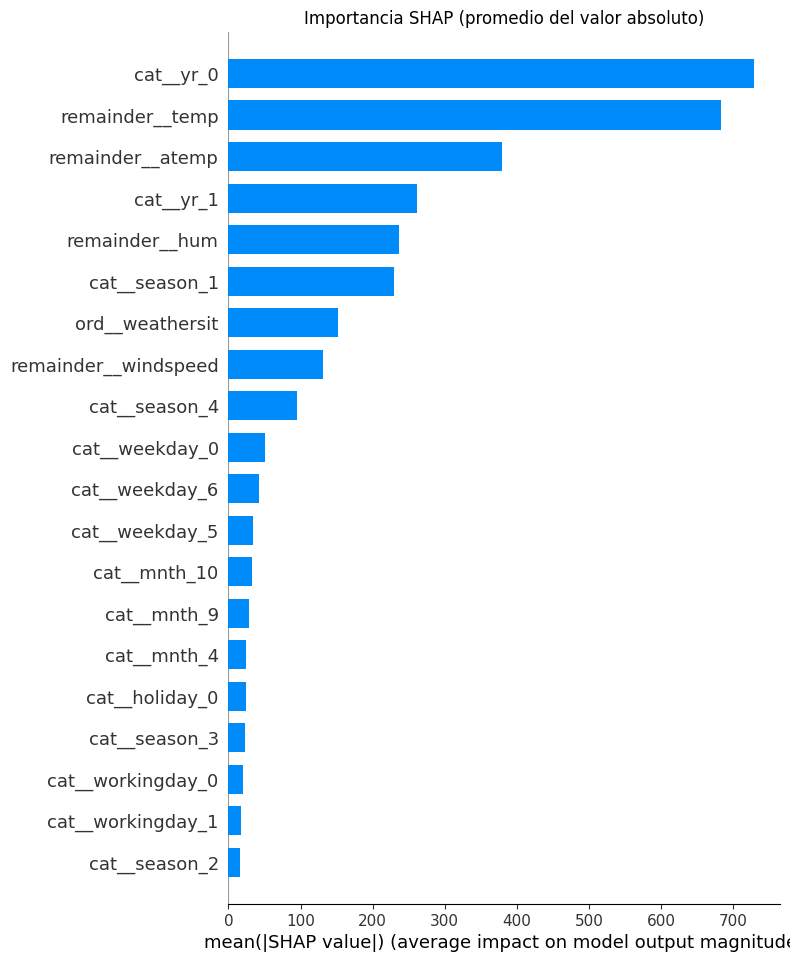

In [78]:
# Ejercicio 9b:

# ************* Inicia sección para agregar tu código:**************************
# Incluye todas las celdas que consideres necesarias.


explainer = shap.TreeExplainer(best_model)
X_train_transformed = preprocessor.transform(X_train)

shap_values = explainer.shap_values(X_train_transformed)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_train_transformed, feature_names=preprocessor.get_feature_names_out(), plot_type='bar', show=False)
plt.title('Importancia SHAP (promedio del valor absoluto)')
plt.show()


### **Ejercicio 9c:**

* **Incluye tu interpretación de los resultados obtenidos. En particular indica las coincidencias y diferencias entre ambos métodos de importancia de factores.**

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Incluye aquí tu respuesta.

**Tanto el año como la temperatura son las cateogrías con más importancia en nuestro arbol de decisiones, lo cual puede significar que sean las primeras categorías que se revisan en el árbol. Tambien significa la temperatura es un factor muy importante para la renta de bicicletas, así como que hubo un año en específico donde fue mejor para el negocio.**

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

## **Ejercicio - 10**

Incluye tus conclusiones finales de la actividad.

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Incluye aquí tu respuesta.

**En la primera parte, observamos como diferentes métricas pueden ofrecernos una mejor idea del comportamiento de nuestros datos. En la segunda parte pudimos ver como los arboles de decisiones nos ayudaron a mejorar hasta un 66% las predicciones sobre la media, además de poder observar los factores importantes en nuestro árbol.**

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# **Fin de la Actividad de modelos basados en árboles**